In [152]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import random
import sys
import torch
import cv2
import torchvision.transforms as transforms
from geovoronoi import voronoi_regions_from_coords
from shapely.geometry import Polygon, mapping
from shapely.ops import cascaded_union, unary_union
import geopandas as gpd
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area, plot_line, plot_polygon_collection_with_color, plot_voronoi_polys, plot_points

In [87]:
# !{sys.executable} -m pip install torchvision.transform

In [121]:
def vor_reg_creator(img_height, img_width, coords):
    area_max_lon = img_width
    area_min_lon = 0
    area_max_lat = img_height
    area_min_lat = 0

    lat_point_list = [area_min_lat, area_max_lat,area_max_lat,area_min_lat]
    lon_point_list = [area_min_lon, area_min_lon, area_max_lon, area_max_lon]

    polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
    boundary = gpd.GeoDataFrame()
    boundary = boundary.append({'geometry': polygon_geom}, ignore_index=True)

    boundary.crs = {'init' :'epsg:3395'}
    boundary_shape = unary_union(boundary.geometry)
    
    region_polys, region_pts = voronoi_regions_from_coords(np.array(tuple(coords)), boundary_shape)
    return region_polys, region_pts, boundary_shape

In [144]:
def vor_plotting(coords, rand_point_no, region_polys, boundary_shape, img_width, img_height, line_width, line_color, img_no):
    fig, ax = subplot_for_map(figsize=(img_height/120, img_width/120))
    crds = np.array(tuple(coords))
    for point_no in range(rand_point_no):
        points = []
        for p_idx in range(len(region_polys[point_no].exterior.coords.xy[0])):
            points.append([region_polys[point_no].exterior.coords.xy[0][p_idx], region_polys[point_no].exterior.coords.xy[1][p_idx]])
        points = np.array(tuple(points))
        plot_line(ax, points, linewidth=line_width, color=line_color)
    plot_voronoi_polys_with_points_in_area(ax, boundary_shape, region_polys, crds, points_color='white', voronoi_color='white', voronoi_edgecolor='blue')
    plt.title('Image {}'.format(img_no+1))
    plt.xlim(0, img_width)
    plt.ylim(0, img_height)
    #plt.show()
    plt.savefig('Image {}'.format(img_no+1)+'.png', dpi=120, format='png')
    plt.close()

In [145]:
def vor_img_creator_trial(total_img, rand_point_no, img_height, img_width):
    for img_no in range(total_img):
        vor_arr = []
        for point_no in range(rand_point_no):
            y_axis = random.uniform(0.0, img_height)
            x_axis = random.uniform(0.0, img_width)
            vor_arr.append([x_axis, y_axis])
        vor = Voronoi(vor_arr)
        fig = voronoi_plot_2d(vor)
        plt.title('Image {}'.format(img_no))
        plt.xlim(0, img_width)
        plt.ylim(0, img_height)
        plt.savefig('Image {}'.format(img_no)+'.png')
        plt.close()

In [146]:
def vor_bw_img_creator(total_img, rand_point_no, img_height, img_width, line_width, line_color):
    for img_no in range(total_img):
        coords = []
        for point_no in range(rand_point_no):
            y_axis = random.uniform(0.0, img_height)
            x_axis = random.uniform(0.0, img_width)
            coords.append([x_axis, y_axis])
        region_polys, region_pts, boundary_shape = vor_reg_creator(img_height, img_width, coords)
        vor_plotting(coords, rand_point_no, region_polys, boundary_shape, img_width, img_height, line_width, line_color, img_no)

In [200]:
vor_bw_img_creator(3, 8, 30, 45, 2, 'black')

In [201]:
def img_to_tensor_bw(img, img_height, img_width):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).reshape(img_width, img_height, 1)
    transform = transforms.Compose([transforms.ToTensor()])
    tensor = transform(image)
    return tensor

In [204]:
def tensor_out_bw(total_img, img_height, img_width):
    output = img_to_tensor_bw('Image {}'.format(1)+'.png', img_height, img_width)
    for idx in range(total_img-1):
        output = torch.cat((output, img_to_tensor_bw('Image {}'.format(idx+2)+'.png', img_height, img_width)))
    output = output.reshape(total_img, 1, img_width, img_height)
    return output

In [206]:
output = tensor_out_bw(3, 30, 45)
print(output.shape)

torch.Size([3, 1, 45, 30])


In [58]:
img_width = 20
img_height = 10
rand_point_no = 8
line_width = 2
line_color = 'blue'
coords = []
for point_no in range(rand_point_no):
    y_axis = random.uniform(0.0, img_height)
    x_axis = random.uniform(0.0, img_width)
    coords.append([x_axis, y_axis])

In [59]:
area_max_lon = img_width
area_min_lon = 0
area_max_lat = img_height
area_min_lat = 0

lat_point_list = [area_min_lat, area_max_lat,area_max_lat,area_min_lat]
lon_point_list = [area_min_lon, area_min_lon, area_max_lon, area_max_lon]

polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
boundary = gpd.GeoDataFrame()
boundary = boundary.append({'geometry': polygon_geom}, ignore_index=True)

boundary.crs = {'init' :'epsg:3395'}
boundary_shape = unary_union(boundary.geometry)

region_polys, region_pts = voronoi_regions_from_coords(np.array(tuple(coords)), boundary_shape)

C:\Users\CEM\miniconda3\lib\site-packages\geovoronoi\plotting.py:348: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  color_values = color_values[np.nonzero(geoms_indices[multi_indices][..., np.newaxis] == color_indices)[1]]


ValueError: Unknown geometry type: featurecollection

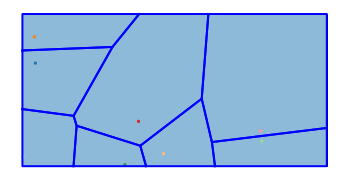

In [62]:
fig, ax = subplot_for_map()
crds = np.array(tuple(coords))

for point_no in range(rand_point_no):
    points = []
    for p_idx in range(len(region_polys[point_no].exterior.coords.xy[0])):
        points.append([region_polys[point_no].exterior.coords.xy[0][p_idx], region_polys[point_no].exterior.coords.xy[1][p_idx]])
    points = np.array(tuple(points))
    plot_line(ax, points, linewidth=line_width, color=line_color)
plot_voronoi_polys_with_points_in_area(ax, boundary_shape, region_polys, crds, region_pts)
plot_polygon_collection_with_color(ax, [boundary], color='yellow', edgecolor='blue')
plt.title('Image {}'.format(1))
plt.xlim(0, img_width)
plt.ylim(0, img_height)
plt.show()